want to use torch (0-no , 1-yes):  0
algorithm name:  SAC
Episode Length:  250


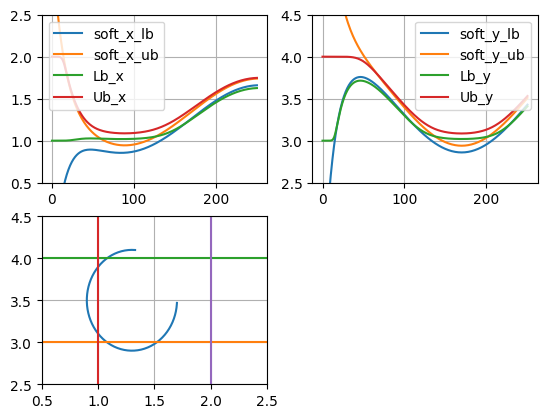

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
[ 1.21984282  3.12508057 -1.6689955 ]


In [22]:
from stable_baselines3 import HerReplayBuffer, PPO, SAC
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.evaluation import evaluate_policy
import gymnasium as gym
import numpy as np
import time
import matplotlib.pyplot as plt
from gymnasium.envs.registration import register

 

Use_torch = int(input("want to use torch (0-no , 1-yes): "))
algorithm_name = input("algorithm name: ")
EpiLen = input("Episode Length: ")

 

if Use_torch == 0:
    register(
        # unique identifier for the env `name-version`
        id="RobotEnv-v0",
        # path to the class for creating the env
        # Note: entry_point also accept a class as input (and not only a string)
        entry_point="Robot_env:RobotEnv",
        kwargs={'epi_len': int(EpiLen)},
    )
else:
    register(
        # unique identifier for the env `name-version`
        id="RobotEnv-v0",
        # path to the class for creating the env
        # Note: entry_point also accept a class as input (and not only a string)
        entry_point="Robot_env_torch:RobotEnv",
        kwargs={'epi_len': int(EpiLen)},
    )
env = gym.make("RobotEnv-v0", env_kwargs={"epi_len": EpiLen})
# model_folder_name = "./model/"+"model_"+algorithm_name+"_"+EpiLen+"EpiLen"
# model_path = "./models/"+algorithm_name+"/model_"+algorithm_name+"_"+EpiLen+"EpiLen"
model_path = "./best_models/"+algorithm_name+"/best_model_"+algorithm_name+"_"+EpiLen+"EpiLen"
if algorithm_name=="PPO":
    model = PPO.load(model_path, env=env)
elif algorithm_name=="SAC":
    model = SAC.load(model_path, env=env)

 

x_min,x_max,y_min,y_max = [],[],[],[]
x_state,y_state,theta_state,rew = [],[],[],[]
for _ in range(1):
    obs, info = env.reset()
    print(obs)
    for i in range(int(EpiLen)):
        action, _ = model.predict(obs, deterministic=True)
        action = np.clip(action,env.action_space.low, env.action_space.high)
        obs, reward, terminated, truncated, info = env.step(action)
        x_state.append(obs[0])
        y_state.append(obs[1])
        theta_state.append(obs[2])
        rew.append(reward)
        x_min.append(info['x_min'])
        x_max.append(info['x_max'])
        y_min.append(info['y_min'])
        y_max.append(info['y_max'])

        if terminated or truncated:
            obs, info = env.reset()
            break
    env.render()
env.close()

Text(0, 0.5, 'y - state')

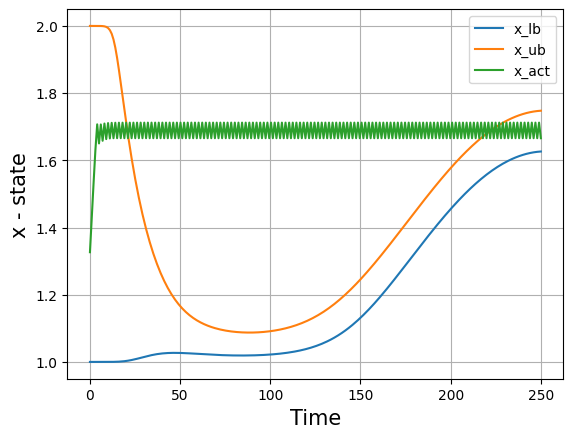

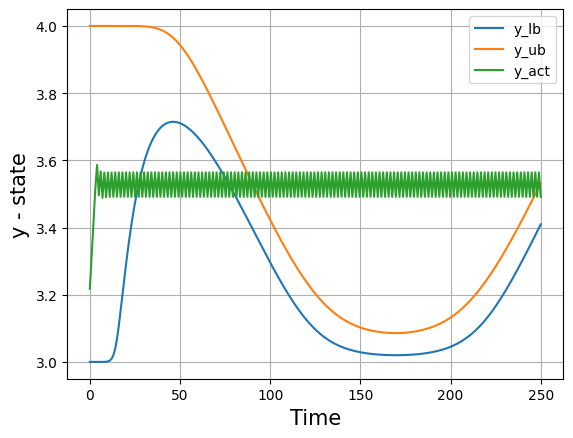

In [23]:
#plots of state x,y

time = np.linspace(0,int(EpiLen),int(EpiLen))
plt.plot(time,x_min,time,x_max,time,x_state)
plt.xlabel("Time",fontsize=15)
plt.ylabel('x - state',fontsize=15)
plt.legend(['x_lb','x_ub','x_act'])
plt.grid()
plt.figure()
plt.plot(time,y_min,time,y_max,time,y_state)
plt.legend(['y_lb','y_ub','y_act'])
plt.grid()
plt.xlabel("Time",fontsize=15)
plt.ylabel('y - state',fontsize=15)

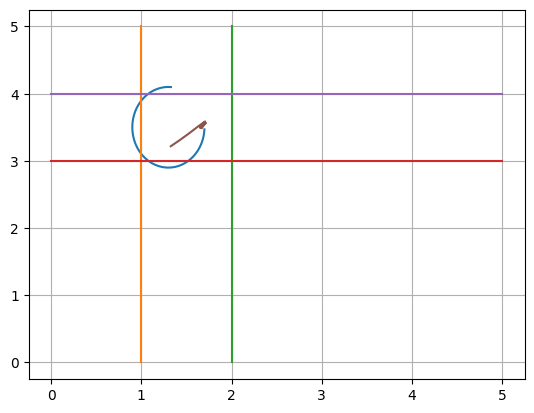

In [24]:
time = np.linspace(0,5,int(EpiLen))
time_int = 0.01
xd=[[1.3+0.4*np.cos(1.9*time_int*t+1.5), 3.5+0.6*np.sin(1.9*t*time_int+1.5)] for t in range(int(EpiLen))]
state_d = np.array(xd)
x_lb_hard = [1 for i in range(int(EpiLen))]
x_ub_hard = [2 for i in range(int(EpiLen))]
lb_hard_y = [3 for i in range(int(EpiLen))]
ub_hard_y = [4 for i in range(int(EpiLen))]
plt.plot(state_d[:,0],state_d[:,1],x_lb_hard,time,x_ub_hard,time,time,lb_hard_y,time,ub_hard_y,x_state,y_state)
plt.grid()

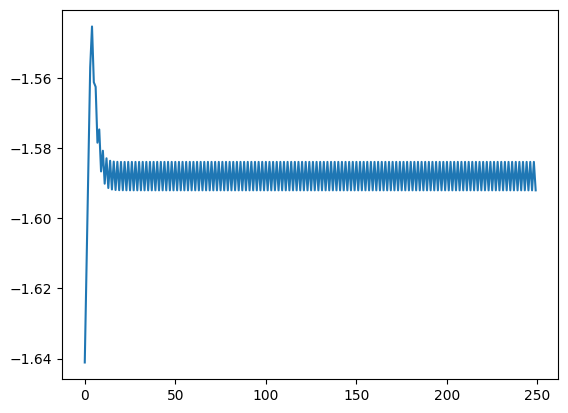

In [25]:
plt.plot(theta_state)


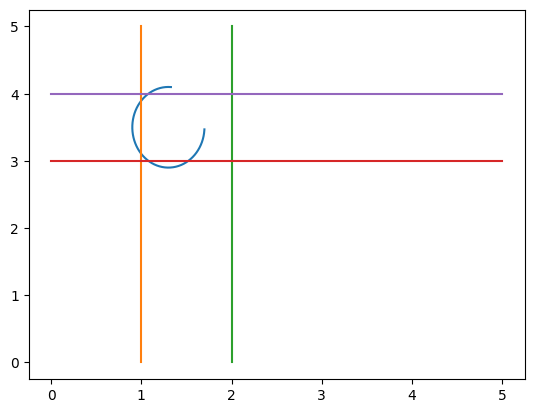

In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
EpiLen = 250
time = np.linspace(0,5,EpiLen)
time_int = 0.01
xd=[[1.3+0.4*math.cos(1.9*time_int*t+1.5), 3.5+0.6*math.sin(1.9*t*time_int+1.5)] for t in range(EpiLen)]
state_d = np.array(xd)
x_lb_hard = [1 for i in range(EpiLen)]
x_ub_hard = [2 for i in range(EpiLen)]
lb_hard_y = [3 for i in range(EpiLen)]
ub_hard_y = [4 for i in range(EpiLen)]
plt.plot(state_d[:,0],state_d[:,1],x_lb_hard,time,x_ub_hard,time,time,lb_hard_y,time,ub_hard_y)

In [56]:
lb_hard_cons = [1,3]
ub_hard_cons = [2,4]
def max_initial_funnel_width(state_d):
    rho_0_point=[np.array([lb_hard_cons[0],lb_hard_cons[1]]),
                 np.array([lb_hard_cons[0],ub_hard_cons[1]]),
                 np.array([ub_hard_cons[0],lb_hard_cons[1]]),
                 np.array([ub_hard_cons[0],ub_hard_cons[1]])]
    distances = [np.linalg.norm(state_d[0] - point) for point in rho_0_point]
    print(distances)
    return rho_0_point[np.argmax(distances)]

[1.1465047623201252, 0.34275236847884893, 1.2875882139444133, 0.6788883743029471]


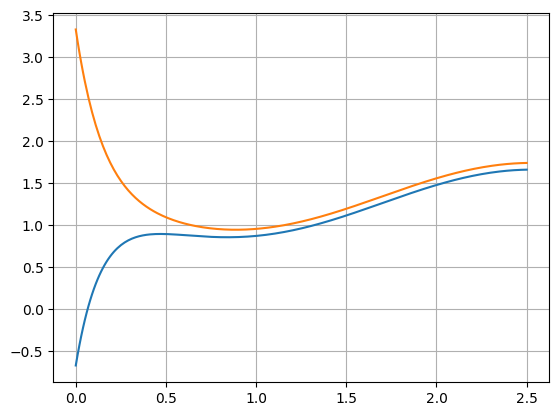

In [57]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
# x = -6
# y = -4
# theta = 0
l = np.array([7,7])
rho_f = np.array([0.04,0.04])
rho_0 = abs(max_initial_funnel_width(state_d))
gamma = np.array([(rho_0 - rho_f)*np.exp(-l*time_int*t) + rho_f for t in range(EpiLen)])
lb_soft = state_d - gamma
ub_soft = state_d + gamma
phi_ini_L = [0,0]
phi_ini_U = [0,0]
time = np.linspace(0,time_int*EpiLen,EpiLen)
plt.plot(time,lb_soft[:,0],time,ub_soft[:,0])
plt.grid()



In [58]:
def bound(phi,t,lb, ub, mu, kc):
    eta = ub-lb
    # print(eta)
    dphi_dt = 0.5*(1-np.sign(eta-mu))*(1/(eta+phi+1e-7))-kc*phi
    return dphi_dt
  #    --------ADD FUNNEL HERE---------
def funnel(lb_soft, ub_soft, phi_ini_L, phi_ini_U):
    mu = np.array([5,5])   #For different states
    kc = np.array([80, 80])   #For different states
    # Hard Constraints - Boundary
    lb_hard = np.array([1, 3])
    ub_hard = np.array([2, 4])

    # Soft Constraints - Trajectory tracking-as input
    t1 = [0,time_int]
    t, phi_L = odeint(bound, phi_ini_L, t1, args=(lb_soft, ub_hard, mu, kc))
    phi_sol_L = phi_L #np.abs(phi_L)
    t, phi_U = odeint(bound, phi_ini_U, t1, args=(lb_hard, ub_soft, mu, kc))
    phi_sol_U = phi_U #np.abs(phi_U)
    v = 10
    Lb = np.log(np.exp(v * (lb_soft - phi_sol_L)) + np.exp(v * lb_hard)) / v
    Ub = -np.log(np.exp(-v * (ub_soft + phi_sol_U)) + np.exp(-v * ub_hard)) / v
    return phi_sol_L, phi_sol_U, Lb, Ub

In [61]:
low_bound,upper_bound,time = [],[],[]
for j in range(EpiLen):
  phi_sol_L,phi_sol_U,Lb,Ub = funnel(lb_soft[j,:],ub_soft[j,:],np.array(phi_ini_L),np.array(phi_ini_U))
  phi_ini_L = phi_sol_L
  phi_ini_U = phi_sol_U
  low_bound.append(Lb)
  upper_bound.append(Ub)
  time.append(j*time_int)

low_x = [inner_list[0] for inner_list in low_bound]
low_y = [inner_list[1] for inner_list in low_bound]
high_x = [inner_list[0] for inner_list in upper_bound]
high_y = [inner_list[1] for inner_list in upper_bound]

lb_hard_x = [1 for i in range(EpiLen)]
ub_hard_x = [2 for i in range(EpiLen)]
lb_hard_y = [3 for i in range(EpiLen)]
ub_hard_y = [4 for i in range(EpiLen)]


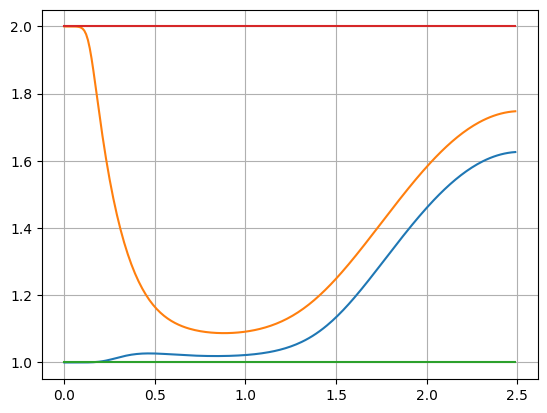

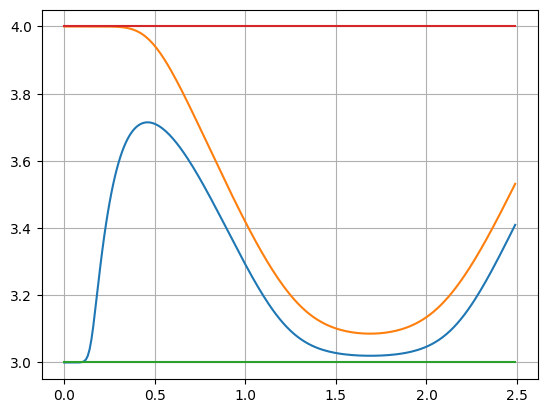

In [63]:
plt.plot(time,low_x,time,high_x,time, lb_hard_x,time,ub_hard_x)
plt.grid()
plt.figure()gamma_upp = np.array([((rho_0 - self.state_d[0]) - rho_f)*np.exp(-l*self.time_int*t) + rho_f for t in range(ref_traj_length)])
        # gamma_low = np.array([((rho_0 + self.state_d[0]) - rho_f)*np.exp(-l*self.time_int*t) + rho_f for t in range(ref_traj_length)])
plt.plot(time, low_y,time,high_y,time, lb_hard_y,time,ub_hard_y)
plt.grid()

In [ ]:
t=np.linspace(-10,10,epi_len)
for _ in range(epi_len):
    x_min,y_min = low_x[_],low_y[_]
    x_max,y_max = high_x[_],high_y[_]
    Rew_max_x = abs(x_max - x_min)
    robust1 = Rew_max_x - ((t - (x_min + x_max)/2)**2)*(4*Rew_max_x/((x_max-x_min)**2))
    Rew_max_y = abs(y_max - y_min)
    robust2 = Rew_max_y - ((t - (y_min + y_max)/2)**2)*(4*Rew_max_y/((y_max-y_min)**2))
    